<a href="https://colab.research.google.com/github/pinakm9/sphere-fp/blob/master/data/4D/sphere4D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required modules**

In [5]:
# run this cell to download data and necessary modules
import os, shutil
repo = 'sphere-fp'
if os.path.isdir(repo):
  shutil.rmtree(repo)
!git clone https://github.com/pinakm9/sphere-fp.git
# add modules folder to Python's search path
import sys
sys.path.insert(0, repo + '/modules')
# import the necessary modules
import numpy as np
import tensorflow as tf
import lss_solver as lss
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Cloning into 'sphere-fp'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 108 (delta 33), reused 94 (delta 21), pack-reused 0
Receiving objects: 100% (108/108), 26.01 MiB | 18.00 MiB/s, done.
Resolving deltas: 100% (33/33), done.


**Define the equation through the $\mathcal L_{\log}$ operator**

In [10]:
DTYPE = tf.float32
D = 1.0
dim = 4
ones = np.ones(dim)
domain = [-2. * ones, 2. * ones]
save_folder = '{}/data/{}D'.format(repo, dim)

@tf.function
def diff_log_op(f, x, y, x1, y1):
    z = 4.*(x**2 + y**2 - 1.) 
    z1 = 4.*(x1**2 + y1**2 - 1.)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y, x1, y1])
        f_ = f(x, y, x1, y1)
        f_x, f_y, f_x1, f_y1 = tape.gradient(f_, [x, y, x1, y1])
    f_xx = tape.gradient(f_x, x)
    f_yy = tape.gradient(f_y, y)
    f_x1x1 = tape.gradient(f_x1, x1)
    f_y1y1 = tape.gradient(f_y1, y1)
    return z*(x*f_x + y*f_y) + z1*(x1*f_x1 + y1*f_y1) + 4.*(z+ z1 + dim) + D*(f_x**2 + f_y**2 + f_xx + f_yy + f_x1**2 + f_y1**2 + f_x1x1 + f_y1y1) 

**Define the steady state $p_\infty(\mathbf x)$**

In [11]:
from scipy.special import erf
import numpy as np

def p_inf2(x, y):
  Z = 0.5 * np.sqrt(np.pi**3 * D) * (1. + erf(1/np.sqrt(D)))
  return tf.exp(-(x**2 + y**2 - 1.)**2 / D) / Z 

def p_inf(x, y, x1, y1):
  return p_inf2(x, y) * p_inf2(x1, y1)

**Set up experiment parameters and learn the stationary distribution**

In [12]:
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000, 10000], [5e-3, 1e-3, 5e-4, 1e-4])
optimizer = tf.keras.optimizers.Adam(learning_rate)
solver = lss.LogSteadyStateSolver(num_nodes=50, num_blocks=3, dtype=DTYPE, name='sphere{}D'.format(dim), diff_log_op=diff_log_op, optimizer=optimizer, domain=domain)
solver.learn(epochs = 5000, n_sample = 1000, save_folder=save_folder)

 Epoch        Loss        Runtime(s)
     0 6258.306152            7.0850
    10 3641.767090            7.3536
    20 1071.509644            7.5931
    30  386.439636            7.8361
    40  181.546463            8.0733
    50  124.993080            8.3094
    60  104.863159            8.5460
    70   91.694664            8.7940
    80   80.372185            9.0350
    90   82.098221            9.2618
   100   69.757164            9.5136
   110   61.194378            9.7668
   120   59.647747           10.0021
   130   55.024059           10.2396
   140   47.828743           10.4759
   150   49.075314           10.7295
   160   46.609989           10.9612
   170   39.273376           11.1935
   180   36.289219           11.4344
   190   37.591393           11.6913
   200   32.558414           11.9540
   210   31.752571           12.2029
   220   29.931049           12.4390
   230   28.282532           12.6779
   240   28.240839           12.9268
   250   24.967749           13.1852
 

**Visualize the learned distribution**

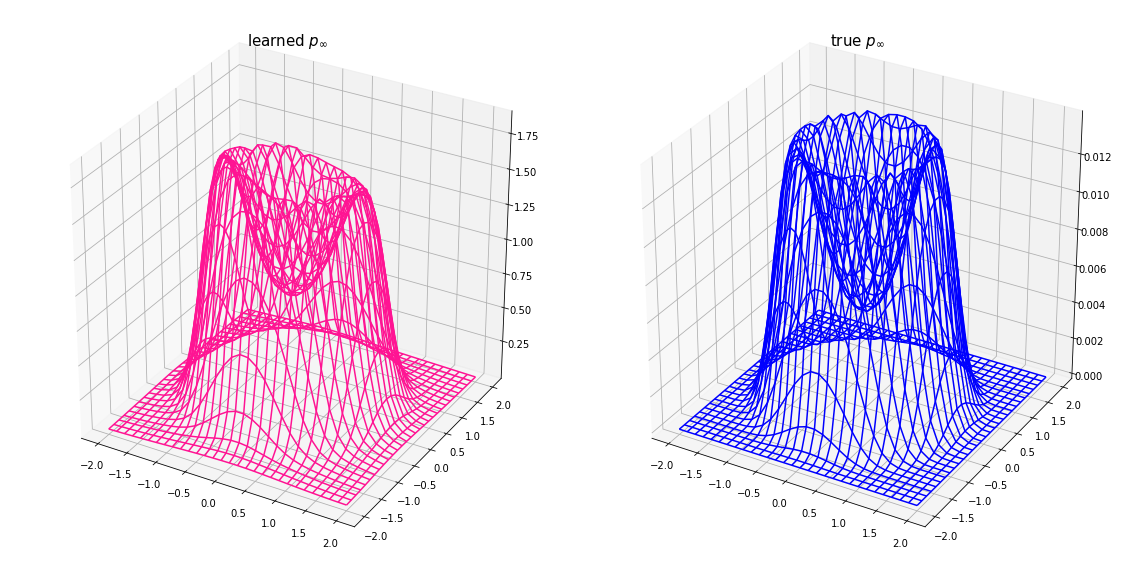

In [14]:
import matplotlib.pyplot as plt

def plot_solutions(learned, true, resolution=30, low=[-2., -2, -2., -2], high=[2., 2., 2., 2.]):
  fig = plt.figure(figsize=(16, 8))
  ax_l = fig.add_subplot(121, projection='3d')
  ax_t = fig.add_subplot(122, projection='3d')
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True).astype('float32')
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True).astype('float32')
  y = np.repeat(y, resolution, axis=0).reshape((-1, 1))
  x = np.array(list(x) * resolution).reshape((-1, 1))
  z_l = learned(x, y).numpy()
  z_t = true(x, y).numpy()
  grid = (resolution, resolution)
  x = x.reshape(grid)
  y = y.reshape(grid)
  z_l = z_l.reshape(grid)
  z_t = z_t.reshape(grid)
  ax_l.plot_wireframe(x, y, z_l, color='deeppink')
  ax_l.set_title('learned $p_\infty$', fontsize=15)
  ax_t.plot_wireframe(x, y, z_t, color='blue')
  ax_t.set_title('true $p_\infty$', fontsize=15)
  plt.tight_layout()
  plt.show()
  

plot_solutions(learned=lambda x, y: tf.exp(solver.net(x, y, tf.zeros_like(x), tf.zeros_like(x))), true=lambda x, y: p_inf(x, y, tf.zeros_like(x), tf.zeros_like(x)))

**Investigate the size of $θ$**

In [15]:
solver.net.summary()

Model: "sphere4D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTMForgetBlock (LSTMForget  multiple                 1800      
 Block)                                                          
                                                                 
 LSTMForgetBlock (LSTMForget  multiple                 11000     
 Block)                                                          
                                                                 
 LSTMForgetBlock (LSTMForget  multiple                 11000     
 Block)                                                          
                                                                 
 dense_3 (Dense)             multiple                  51        
                                                                 
 batch_normalization_3 (Batc  multiple                 0 (unused)
 hNormalization)                                          